# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Содержание

* [1. Загрузка и подготовка данных.](#Загрузка-и-подготовка-данных)
* [2. Обучение и проверка модели.](#Обучение-и-проверка-модели)
* [3. Подготовка к расчёту прибыли.](#Подготовка-к-расчёту-прибыли)  
* [4. Расчёт прибыли и рисков.](#Расчёт-прибыли-и-рисков)

## Загрузка и подготовка данных

Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from tqdm import tqdm

RANDOM = 12345
state = RandomState(RANDOM) 

Загрузим данные.

In [2]:
df_1 = pd.read_csv("/datasets/geo_data_0.csv")
df_2 = pd.read_csv("/datasets/geo_data_1.csv")
df_3 = pd.read_csv("/datasets/geo_data_2.csv")

print('Первый датасет')
display(df_1.sample(5))
df_1.info()
print('')

print('----------------------------------------------')
print('Второй датасет')
display(df_2.sample(5))
df_2.info()
print('')

print('----------------------------------------------')
print('Третий датасет')
display(df_3.sample(5))
df_3.info()

Первый датасет


,id,f0,f1,f2,product
89815,vRoQe,1.581175,-0.381228,1.407111,131.846446
44901,h9TNw,-0.284751,1.128217,-2.779204,85.556985
94535,sJkPS,-0.823891,0.597064,7.075726,51.464814
58425,HDmuL,0.527858,0.798474,-3.123894,107.800629
61188,ocjXa,1.193557,-0.538374,4.061362,96.037068


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

----------------------------------------------
Второй датасет


,id,f0,f1,f2,product
57228,tK9hr,7.411635,-2.108015,0.992702,26.953261
8020,uUClY,2.438856,-11.328348,0.010897,3.179103
31251,M9NDt,-2.475872,-6.620834,3.998700,110.992147
49071,u0Aup,-1.471323,-8.986554,4.003888,110.992147
37673,BIoNr,-7.849254,-9.731827,3.997339,110.992147


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

----------------------------------------------
Третий датасет


,id,f0,f1,f2,product
32246,D7CCR,1.745177,0.349746,3.212730,86.233827
50795,IOyMH,1.014732,2.623671,-0.183074,136.225803
51562,JpFbn,0.488106,-0.510178,5.496098,108.461265
69871,o4n3D,2.084213,-2.582814,4.015725,135.985468
19253,Ccrnp,0.346824,-2.764498,6.292081,150.959120


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В данных есть следующие столбцы:
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

Проверим данные на дубликаты.

In [3]:
print(df_1.duplicated().sum())
print(df_2.duplicated().sum())
print(df_3.duplicated().sum())

0
0
0


Дубликатов нет.

Посмотрим на распределение в данных.

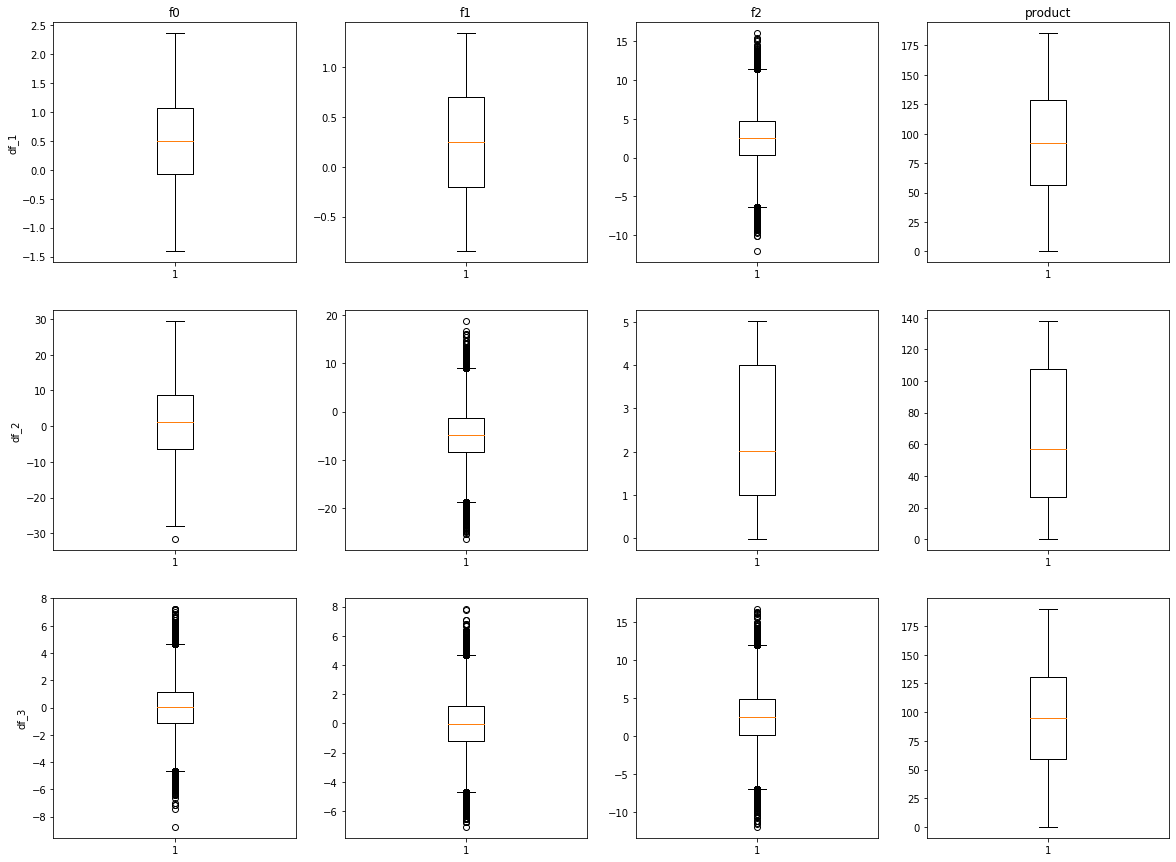

In [4]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

name_df = ["df_1","df_2","df_3"]
columns = df_1.columns[1:]
num_columns_with_columns = zip(df_1.columns[1:], range(4))
name_df_with_columns = zip([df_1, df_2, df_3], range(3))

for column in list(itertools.product(name_df_with_columns, num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])

for row in range(3):
    ax[row][0].set_ylabel(name_df[row])

for column in range(4):
    ax[0][column].set_title(columns[column])

В данных есть выбросы. Разберёмся с ними.

In [5]:
def remove(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Процент строк для удаления: {:.2%}'.format(len(del_index)/len(frame[column])))
    return del_index

noise_data = [(df_1, "f2"),
              (df_2, "f1"),
              (df_3, "f0"),
              (df_3, "f1"),
              (df_3, "f2")]

for frame,column in noise_data:
    indexes = remove(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)
    
df_1 = df_1.reset_index(drop = True)
df_2 = df_2.reset_index(drop = True)
df_3 = df_3.reset_index(drop = True)

Процент строк для удаления: 0.51%
Процент строк для удаления: 0.64%
Процент строк для удаления: 0.73%
Процент строк для удаления: 0.69%
Процент строк для удаления: 0.59%


Потеря данных во всех датасетах меньше 1%.

Проверим датасеты на мультиколлинеарность признаков.

In [6]:
print('Первый датасет')
display(df_1.corr())
print('')
print('---------------------------------')
print('Второй датасет')
display(df_2.corr())
print('')
print('---------------------------------')
print('Третий датасет')
display(df_3.corr())

Первый датасет


,f0,f1,f2,product
f0,1.000000,-0.440716,-0.003339,0.143591
f1,-0.440716,1.000000,0.001098,-0.192748
f2,-0.003339,0.001098,1.000000,0.480159
product,0.143591,-0.192748,0.480159,1.000000



---------------------------------
Второй датасет


,f0,f1,f2,product
f0,1.000000,0.178877,-0.001670,-0.030389
f1,0.178877,1.000000,-0.002756,-0.010174
f2,-0.001670,-0.002756,1.000000,0.999397
product,-0.030389,-0.010174,0.999397,1.000000



---------------------------------
Третий датасет


,f0,f1,f2,product
f0,1.000000,0.000649,0.000473,-0.002962
f1,0.000649,1.000000,0.000710,-0.000895
f2,0.000473,0.000710,1.000000,0.441211
product,-0.002962,-0.000895,0.441211,1.000000


Мультиколлинеарности признаков нет.

## Обучение и проверка модели

In [7]:
array_name = ["df_1", "df_2", "df_3"]

array_frame = [df_1, df_2, df_3]

data_dict = {"pipelines":{},"scores":{},"valid":{}}

for frame, name in zip(array_frame, array_name):
    
    features = frame.drop(["id","product"], axis = 1)
    target = frame["product"]
    
    (features_train, features_valid, target_train, target_valid) = train_test_split(
        features, target, test_size = 0.25, random_state = RANDOM)
    
    data_dict['valid'][name] = (features_valid, target_valid)
    
    new_pipeline = make_pipeline(StandardScaler(), LinearRegression())
    new_pipeline.fit(features_train, target_train)
    
    data_dict['pipelines'][name] = new_pipeline
    data_dict['scores'][name] = mean_squared_error(target_valid, new_pipeline.predict(features_valid))**0.5
   
print('Среднеквадратичная ошибка')
display(data_dict['scores'])

Среднеквадратичная ошибка


{'df_1': 37.922930890531454,
 'df_2': 0.889447814640159,
 'df_3': 40.17679711012713}

In [8]:
best_model_df_1 = data_dict['pipelines']['df_1']
best_model_df_2 = data_dict['pipelines']['df_2']
best_model_df_3 = data_dict['pipelines']['df_3']

predicted_values_df_1 = best_model_df_1.predict(data_dict['valid']['df_1'][0])
predicted_values_df_2 = best_model_df_2.predict(data_dict['valid']['df_2'][0])
predicted_values_df_3 = best_model_df_3.predict(data_dict['valid']['df_3'][0])

RMSE_model_df_1  = (mean_squared_error(data_dict['valid']['df_1'][1],predicted_values_df_1))**0.5
RMSE_model_df_2  = (mean_squared_error(data_dict['valid']['df_2'][1],predicted_values_df_2))**0.5
RMSE_model_df_3  = (mean_squared_error(data_dict['valid']['df_3'][1],predicted_values_df_3))**0.5

df_1_info = {'Средний запас:':predicted_values_df_1.mean(),
            "RMSE модели:":RMSE_model_df_1},
df_2_info = {'Средний запас:':predicted_values_df_2.mean(),
            "RMSE модели:":RMSE_model_df_2},
df_3_info = {'Средний запас:':predicted_values_df_3.mean(),
            "RMSE модели:":RMSE_model_df_3}

print('Первый датасет')
display(df_1_info)
print('')
print('Второй датасет')
display(df_2_info)
print('')
print('Третий датасет')
display(df_3_info)

Первый датасет


({'Средний запас:': 92.72476770114889, 'RMSE модели:': 37.922930890531454},)


Второй датасет


({'Средний запас:': 68.59166978153503, 'RMSE модели:': 0.889447814640159},)


Третий датасет


{'Средний запас:': 94.6771691321233, 'RMSE модели:': 40.17679711012713}

**Вывод**
* Первый регион: средний запас высокий, на втором месте среди других регионов, среднеквадратичная ошибка так же на втором месте, но достаточно большая.
* Второй регион: низкий относительно других регионов средний запас, но ошбка очень маленькая, что является хорошим показателем.
* Третий регион: самый высокий показатель запаса, но и самая высокая ошибка.

## Подготовка к расчёту прибыли

In [9]:
BUDGET = 10**10            #Бюджет на разработку скважин в регионе — 10 млрд рублей
PRE_MAX_POINTS = 500       #При разведке региона исследуют 500 точек, из которых
FINAL_MAX_POINTS = 200     #с помощью машинного обучения выбирают 200 лучших для разработки
PRICE_PER_BARREL = 450000  #Доход с каждой единицы продукта составляет 450 тыс. рублей
DAMAGE_THRESHOLD =  0.025  #вероятность убытков меньше 2.5%

#достаточный объём сырья для безубыточной разработки новой скважины
NON_DAMAGE_POINT = (BUDGET/PRICE_PER_BARREL)/FINAL_MAX_POINTS
print("Достаточный объем добычи для безубыточной разработки",round(NON_DAMAGE_POINT,2))

Достаточный объем добычи для безубыточной разработки 111.11


Судя по средним запасам, ни один из регионов не дотягивает до безубыточного значения.

Попробуем подобрать процент скважин, которые подойдут для достаточного объёма.

In [10]:
print("35% скважин в первом регионе содержат больше сырья, чем ",
      round(df_1["product"].quantile(0.65),2))
print("16% скважин во втором регионе содержат больше сырья, чем ",
      round(df_2["product"].quantile(0.84),2))
print("35% скважин в третьем регионе содержат больше сырья, чем ",
      round(df_3["product"].quantile(0.65),2))

35% скважин в первом регионе содержат больше сырья, чем  113.1
16% скважин во втором регионе содержат больше сырья, чем  134.77
35% скважин в третьем регионе содержат больше сырья, чем  115.36


**Вывод**
* Достаточный объем добычи для безубыточной разработки 111.11 тыс. баррелей.
* Судя по средним запасам, ни один из регионов не дотягивает до безубыточного значения.
* Только 35% скважин в первом регионе, 16% во втором и 35% в третьем регионе проходят порог для безубыточной разработки.

## Расчёт прибыли и рисков 

**Расчёт прибыли**

In [11]:
def income(true_target, pred_target):
    sort_series = pd.Series(pred_target).sort_values(ascending=False)[:FINAL_MAX_POINTS]
    true_target_sort = (true_target.reset_index(drop=True)[sort_series.index])
    sum_true = true_target_sort.sum() 
    return round((sum_true * PRICE_PER_BARREL) - BUDGET_PER_REGION,2)

print("Прибыль с лучших 200 скважин в первом регионе:",
      income(data_dict['valid']['df_1'][1], predicted_values_df_1))
print("Прибыль с лучших 200 скважин во втором регионе:",
      income(data_dict['valid']['df_2'][1], predicted_values_df_2))
print("Прибыль с лучших 200 скважин в третьем регионе:",
      income(data_dict['valid']['df_3'][1],predicted_values_df_3))

Прибыль с лучших 200 скважин в первом регионе: 3346905536.45
Прибыль с лучших 200 скважин во втором регионе: 2415086696.68
Прибыль с лучших 200 скважин в третьем регионе: 2459604164.14


**Расчёт прибыли и рисков с помощью Bootstrap** 

In [12]:
def confidence_interval(true_target,pred_target):
    samples = []
    for i in tqdm(range(1000)):
        sample = pd.Series(pred_target).sample(n = PRE_MAX_POINTS, replace=True, random_state=state)
        samples.append(income(true_target,sample))
    samples = pd.Series(samples)
    print("Средний доход:", samples.mean())
    print("Риск:", samples.apply(lambda x: x < 0).sum()/len(samples)*100,"%")
    
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.975)
    return round(lower,2), round(upper,2)

print("95% доверительный итервал для первого региона:",
      confidence_interval(data_dict['valid']['df_1'][1],pd.Series(predicted_values_df_1)))
print()
print("95% Доверительный итервал для второго региона:",
      confidence_interval(data_dict['valid']['df_2'][1],predicted_values_df_2))
print()
print("95% Доверительный итервал для тервого  региона:",
      confidence_interval(data_dict['valid']['df_3'][1],predicted_values_df_3))

  3%|▎         | 34/1000 [00:00<00:02, 331.25it/s]

Средний доход: 365761564.95741004
Риск: 9.1 %
95% доверительный итервал для первого региона: (-164254187.65, 893337075.24)



  3%|▎         | 32/1000 [00:00<00:03, 316.60it/s]

Средний доход: 437734843.30366004
Риск: 1.9 %
95% Доверительный итервал для второго региона: (51491482.0, 818942568.31)



100%|██████████| 1000/1000 [00:03<00:00, 331.31it/s]

Средний доход: 345027189.33247006
Риск: 10.4 %
95% Доверительный итервал для тервого  региона: (-215797840.7, 896605699.99)


**Вывод**
* Прибыль с 200 лучших скважин превышает достаточный объем добычи для безубыточной разработки.
* При расчёте техникой Bootstrap:
  * Первый регион: средний доход превышает необходимый, риск составляет 9.1%, однако доверительный интервал очень большой.
  * Второй регион: средний доход превышает необходимый, риск составляет 1.9%, доверительный интервал довольно таки большой, но гораздо меньше, чем у других регионов.
  * Третий регион: средний доход превышает необходимый, риск составляет 10.4%, однако доверительный интервал очень большой.
* Таким образом, наилучшим регионом для разработки новых скважин служит второй регион.